# 1. VHM Dataset

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('1-VHM Historical Data.csv')
df = df.iloc[::-1].reset_index(drop=True)  # Reverse the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df1 = df['Price'].str.replace(',', '').astype(float)

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
df1

array([[0.5961768 ],
       [0.62907782],
       [0.5961768 ],
       ...,
       [0.11835614],
       [0.09846435],
       [0.10940484]])

## Ratio 9:1

In [5]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 35ms/step - loss: 0.2436 - val_loss: 0.0282
Epoch 2/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0178 - val_loss: 0.0041
Epoch 3/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0089 - val_loss: 0.0019
Epoch 4/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0022
Epoch 5/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 6/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 7/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 8/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 9/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0015

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 26ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1116.8880533682477
Testing MAPE: 0.016994844766931246
Testing MAE: 745.34515625


In [14]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

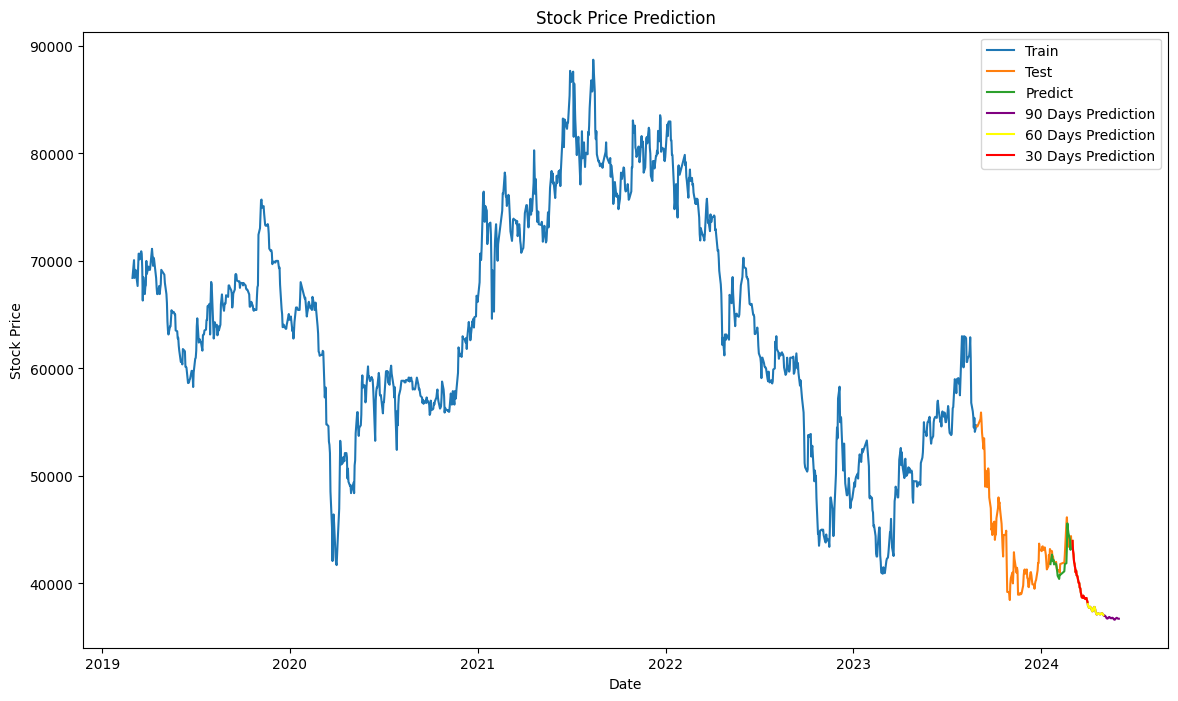

In [15]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 8:2

In [16]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [17]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 37ms/step - loss: 0.0440 - val_loss: 0.0089
Epoch 2/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0068 - val_loss: 0.0035
Epoch 3/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 4/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0013 - val_loss: 0.0014

In [22]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 7ms/step


In [23]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [24]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1317.8774271679204
Testing MAPE: 0.02132626149893413
Testing MAE: 997.7076041666667


In [25]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

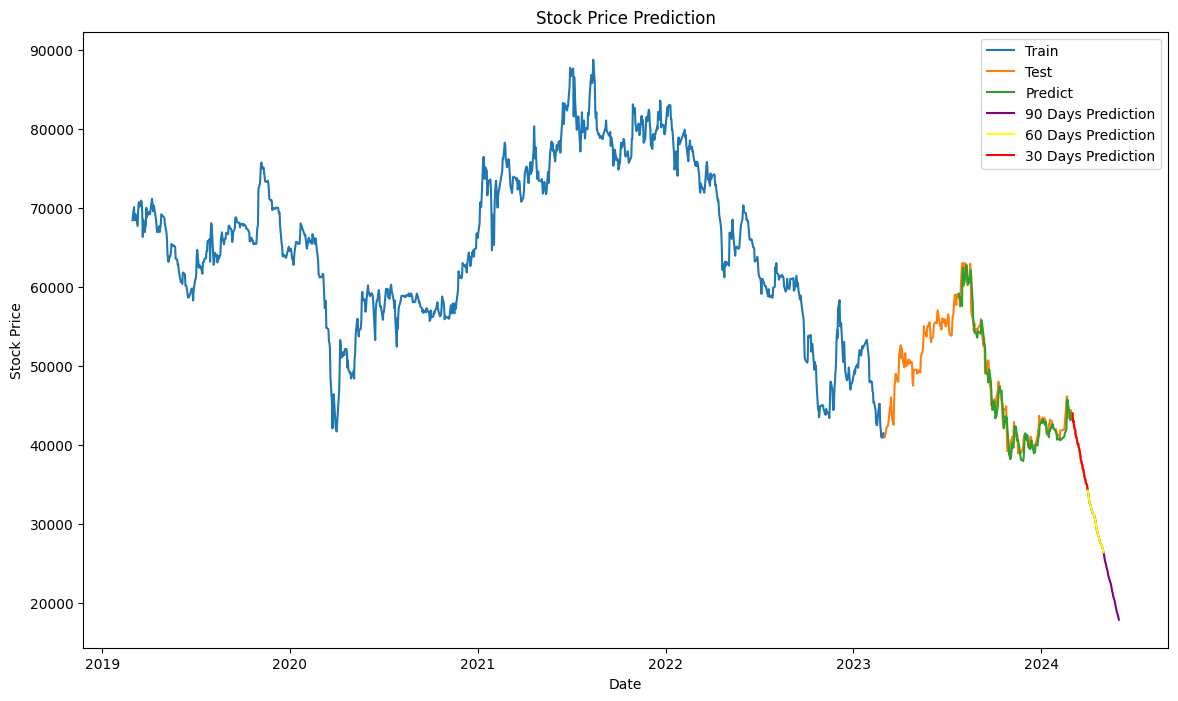

In [26]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 7:3

In [27]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [28]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [30]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [31]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 71ms/step - loss: 0.0155 - val_loss: 0.0128
Epoch 2/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 3/100
13/13 [==============================] - 1s 43ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/100
13/13 [==============================] - 1s 46ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/100
13/13 [==============================] - 1s 44ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 7/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/100
13/13 [==============================] - 0s 23ms/step - loss: 9.6908e-04 - val_loss: 9.

In [33]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

9/9 [==============================] - 0s 7ms/step


In [34]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [35]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1178.2445707378793
Testing MAPE: 0.018233145485460983
Testing MAE: 869.1112073863636


In [36]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


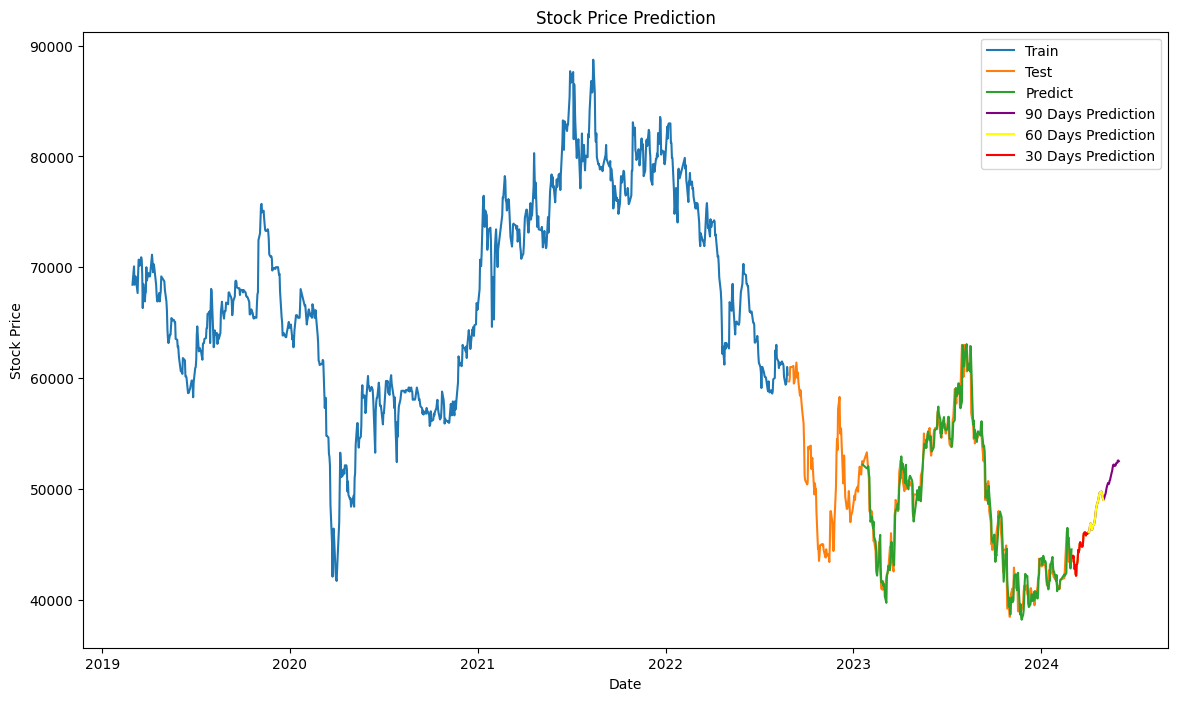

In [37]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


# 2. NVL Dataset

In [38]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [39]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('2-NVL Historical Data.csv')
df = df.iloc[::-1].reset_index(drop=True)  # Reverse the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df1 = df['Price'].str.replace(',', '').astype(float)

In [40]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [41]:
df1

array([[0.27623119],
       [0.27826489],
       [0.27352769],
       ...,
       [0.08220079],
       [0.08341858],
       [0.08585416]])

## Ratio 9:1

In [42]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [43]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [44]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [45]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [46]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [47]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 55ms/step - loss: 0.0420 - val_loss: 5.6863e-04
Epoch 2/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0017 - val_loss: 5.4873e-04
Epoch 3/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0025 - val_loss: 1.1039e-04
Epoch 4/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0011 - val_loss: 1.3470e-04
Epoch 5/100
17/17 [==============================] - 1s 41ms/step - loss: 6.9961e-04 - val_loss: 1.9745e-04
Epoch 6/100
17/17 [==============================] - 0s 27ms/step - loss: 6.2638e-04 - val_loss: 1.0052e-04
Epoch 7/100
17/17 [==============================] - 0s 20ms/step - loss: 6.8278e-04 - val_loss: 1.2940e-04
Epoch 8/100
17/17 [==============================] - 0s 20ms/step - loss: 6.7450e-04 - val_loss: 9.9518e-05
Epoch 9/100
17/17 [==============================] - 0s 21ms/step - loss: 6.2398e-04 - val_loss: 9.4298e-05
Epoch 10/100
17/17 [========================

In [48]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 26ms/step


In [49]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [50]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 312.92454667362915
Testing MAPE: 0.01397353323120519
Testing MAE: 236.9747265625


In [51]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


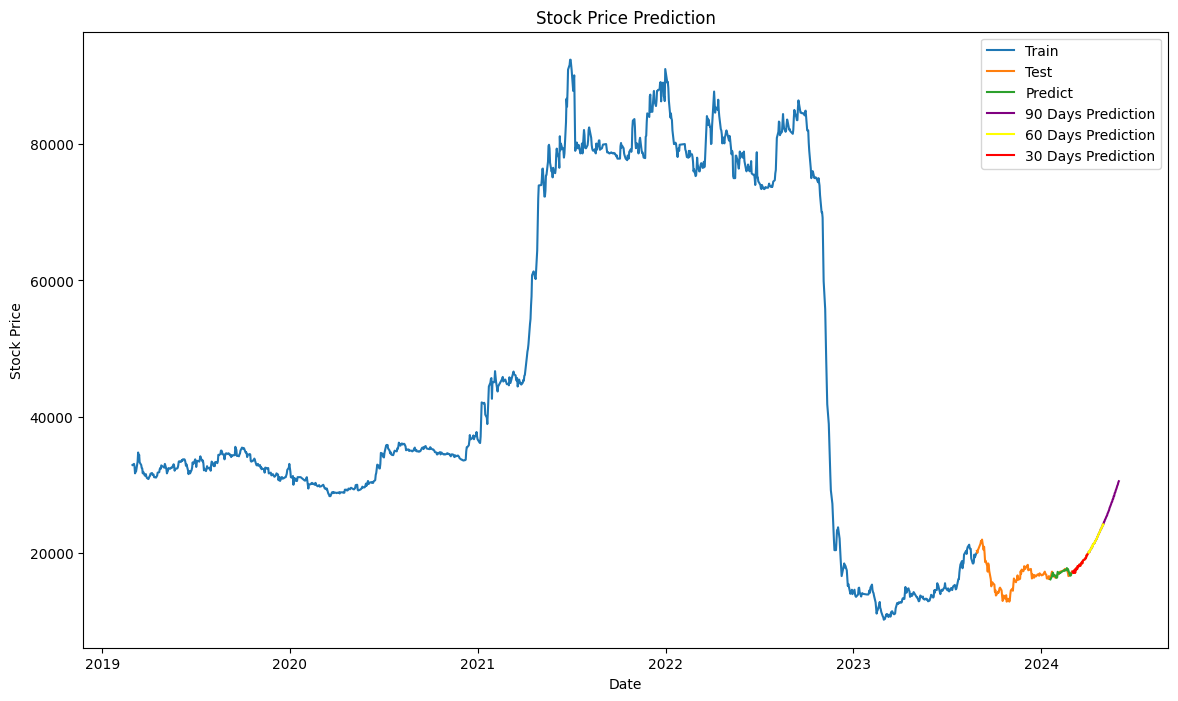

In [52]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 8:2

In [53]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [54]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [55]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [56]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [57]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [58]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 38ms/step - loss: 0.1233 - val_loss: 0.0824
Epoch 2/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0143 - val_loss: 0.0395
Epoch 3/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 4/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0014 - val_loss: 7.4064e-04
Epoch 6/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 5.2193e-04
Epoch 7/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 5.7741e-04
Epoch 8/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 4.7614e-04
Epoch 9/100
15/15 [==============================] - 0s 22ms/step - loss: 9.5203e-04 - val_loss: 4.5051e-04
Epoch 10/100
15/15 [==============================] - 0s 21ms/step - loss: 9

In [59]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 7ms/step


In [60]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [61]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1256.7118834524497
Testing MAPE: 0.058039747399769845
Testing MAE: 980.46283203125


In [62]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 7:3

In [64]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [66]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [67]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [68]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [69]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 72ms/step - loss: 0.1581 - val_loss: 0.0186
Epoch 2/100
13/13 [==============================] - 1s 43ms/step - loss: 0.0069 - val_loss: 0.0169
Epoch 3/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 4/100
13/13 [==============================] - 0s 24ms/step - loss: 8.4160e-04 - val_loss: 0.0038
Epoch 5/100
13/13 [==============================] - 0s 24ms/step - loss: 5.5529e-04 - val_loss: 0.0054
Epoch 6/100
13/13 [==============================] - 0s 24ms/step - loss: 4.0700e-04 - val_loss: 0.0066
Epoch 7/100
13/13 [==============================] - 0s 23ms/step - loss: 3.8724e-04 - val_loss: 0.0049
Epoch 8/100
13/13 [==============================] - 0s 25ms/step - loss: 3.8052e-04 - val_loss: 0.0041
Epoch 9/100
13/13 [==============================] - 0s 23ms/step - loss: 3.7660e-04 - val_loss: 0.0040
Epoch 10/100
13/13 [==============================] - 0s 23ms/step - loss: 3

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# 3. NLG Dataset

In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [ ]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('3-NLG Historical Data.csv')
df = df.iloc[::-1].reset_index(drop=True)  # Reverse the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df1 = df['Price'].str.replace(',', '').astype(float)

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1

## Ratio 9:1

In [79]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [82]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [83]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [84]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 35ms/step - loss: 0.0244 - val_loss: 0.0050
Epoch 2/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0029 - val_loss: 5.8769e-04
Epoch 3/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 6.9570e-04
Epoch 4/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0015 - val_loss: 3.0155e-04
Epoch 5/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 4.9143e-04
Epoch 6/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0010 - val_loss: 3.1161e-04
Epoch 7/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 9.8435e-04
Epoch 8/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 4.3115e-04
Epoch 9/100
17/17 [==============================] - 0s 21ms/step - loss: 9.3498e-04 - val_loss: 3.1386e-04
Epoch 10/100
17/17 [==============================] - 0s 21ms/st

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 8:2

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [98]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1069.2222431262585
Testing MAPE: 0.021623900825766578
Testing MAE: 775.5718619791667


In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 7:3

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

In [110]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

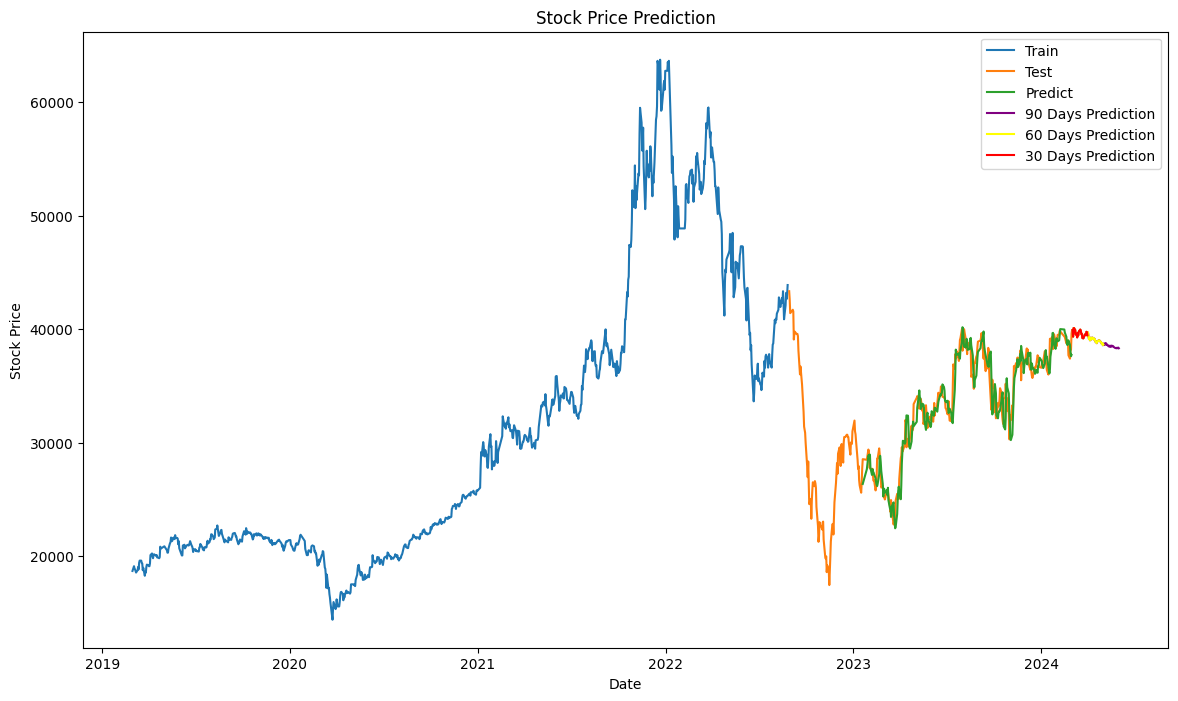

In [111]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()